In [1]:
# import matplotlib.pyplot as plt
import csv
import math
import plotly.graph_objects as go
import numpy as np
from jupyter_client.connect import channel_socket_types
from prompt_toolkit.key_binding.bindings.named_commands import uppercase_word
import pandas as pd
from scipy.fft import fft, ifft
from experiment_loader import load_2d_experiment, load_3d_experiment
from modeling import *
from plotly.subplots import make_subplots

# plt.rcParams['figure.figsize'] = [25, 15]

In [2]:
PLOT_WIDTH = 2000
PLOT_HEIGHT = 1000

In [4]:
channels, channel_meas = load_2d_experiment("./lut_channnel_sweep.csv")
filters, filter_meas = load_2d_experiment("./lut_filter_sweep.csv")
inputs, input_meas = load_2d_experiment("./lut_input_sweep.csv")
channel_cf, filters_cf, channel_filter_meas = load_3d_experiment("./lut_channel_filter_sweep.csv")

In [31]:
import scipy
from collections import Counter
from itertools import repeat, chain

with open('./lut_filter_sweep.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    rows = list(spamreader)
    filters = [int(row[0]) for row in rows]
    filter_meas = [float(row[1]) for row in rows]
fig = go.Figure()
fig.add_trace(go.Scatter(x=filters, y=filter_meas, name="Filter Measurements"))
deltas = []
for i in range(1, len(filter_meas)):
    deltas.append((filter_meas[i] - filter_meas[i-1]) / filter_meas[i-1])


peaks = scipy.signal.find_peaks(deltas, prominence=0.1)[0]
distances = []

for (fpidx, first_peak) in enumerate(peaks):
    for (spidx, second_peak) in enumerate(peaks[fpidx+1:]):
        distances.append(int(second_peak - first_peak))

print(set(list(chain.from_iterable(repeat(i, c) for i,c in Counter(distances).most_common()))))


counted_distances = {int(d):distances.count(d) for d in distances}
print(counted_distances)
fig.add_trace(go.Scatter(x=filters[1:], y=deltas, name="Deltas"))

fig.update_layout(
    autosize=False,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

{128, 256, 2, 64, 192, 320, 448, 384, 51, 115, 117, 53, 245, 373, 501, 243, 371, 499}
{2: 1, 53: 1, 117: 1, 245: 1, 373: 1, 501: 1, 51: 1, 115: 1, 243: 1, 371: 1, 499: 1, 64: 1, 192: 1, 320: 1, 448: 1, 128: 3, 256: 2, 384: 1}


In [53]:
from scipy.fft import fft, fftfreq
import numpy as np

# Same signal creation...

# Perform FFT
bins = 512
offset = 7
signal = deltas[offset:offset + bins]
print(len(deltas))
print(len(signal))
fft_result = fft(signal)

n = len(fft_result)
frequencies = fftfreq(n, 1)[:n//2]
magnitude = 2 * np.abs(fft_result[:n//2]) / n
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=channels[1:], y=deltas, name="Point to point variance", line=dict(color="lightgreen")), secondary_y=True)
fig.add_trace(go.Scatter(x=frequencies, y=magnitude, name="Point to point variance", line=dict(color="lightgreen")), secondary_y=True)
mean_magnitude = np.mean(magnitude)

for (mag, freq) in sorted(zip(magnitude, frequencies), reverse=True):
    if freq > 0 and mag > mean_magnitude:
        print(round(1 / freq), mag)
fig.show()

519
512
3 0.011529798490623527
8 0.011018339516873097
2 0.010488638313461234
6 0.01048285382971875
2 0.010369939705991583
11 0.010319472120474231
2 0.010303797319663056
16 0.01026855857191239
4 0.010266081885202375
5 0.010229559414535714
5 0.010216821373415752
3 0.010208365688023633
7 0.010157034860843382
3 0.010096830413499321
3 0.010046941341063093
9 0.01004246789066117
4 0.009956593495033333
32 0.009954941056398795
3 0.009923591082385178
64 0.00989939118656365
4 0.009882073907374276
21 0.009856704651912657
2 0.009855192310081065
3 0.00983958131075228
2 0.009788774783473932
3 0.009773301692415259
13 0.009764653468833066
4 0.009651274566279488
5 0.009603297511165579
2 0.009598040273550332
6 0.009458176272796265
7 0.005384281960352113
5 0.005263143173209485
2 0.0052424427108239725
10 0.005229952074663707
2 0.0051845645745922575
4 0.005094322970296742
3 0.005086874294319761
43 0.00508472542420535
2 0.005065113770353631
3 0.005062557326239667
3 0.00505766118526627
5 0.0050382143896149124

In [32]:
with open('./consuming_channnel_sweep.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    rows = list(spamreader)
    filters = [int(row[0]) for row in rows]
    filter_meas = [float(row[1]) for row in rows]
fig = go.Figure()
fig.add_trace(go.Scatter(x=filters, y=filter_meas, name="Filter Measurements"))

fig.update_layout(
    autosize=False,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

In [6]:


# Read data from a csv
df = pd.read_csv('./lut_channel_filter_sweep.csv', usecols=["channels", "filters", "ms"])
split_df = df.groupby('channels')
fig = go.Figure()

x_unique = list(set(df["channels"]))
x_unique.sort()
y_unique = list(set(df["filters"]))
y_unique.sort()
# print(y_unique)
z = []
for y in y_unique:
    z.append([])
    for x in x_unique:
        z[-1].append(df.loc[df["channels"] == x].loc[df["filters"] == y]["ms"].values[0])
# np.reshape([x.shape[0], y.shape[0]])
# print(z)
fig.add_trace(go.Scatter3d(
    x=df['channels'],
    y=df['filters'],
    z=df['ms'],
    mode='markers',
    marker=dict(size=7),
    # name=f"channel {category}",
    # mode='markers+lines',
    line=dict(
        dash='dash',
        width=.5
    )
))
fig.add_trace(go.Surface(
    x=x_unique,
    y=y_unique,
    z=z,
))
# Customize the plot
fig.update_layout(
    scene=dict(
        xaxis_title='channels',
        yaxis_title='filters',
        zaxis_title='ms'
    ),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
        template='plotly_white',
)
fig.layout.scene.camera.projection.type = "orthographic"
# Display the plot
fig.show()


In [7]:
fig = go.Figure()
split_df = df.groupby('channels')
first = True
# deltas = []
# approx = split_df.get_group(100)

# lv = list(approx['ms'])[0]
# for meas in list(approx['ms'])[1:]:
#     deltas.append((meas / lv))
#     lv = meas
deltas = calculate_deltas(list(split_df.get_group(120)['ms']))
for category, category_df in split_df:
    # print(category_df)
    # if not first:
    #    continue
    upper_right = 195
    upper_left = 129
    lower_right = 192
    lower_left = 126
    # # upper_m, upper_b = lin_interpol( upper_sampled_channels[0], upper_sampled_channels[1], upper_sampled_channel_meas[0], upper_sampled_channel_meas[1])

    upper_right_meas = category_df.loc[category_df["filters"] == upper_right]["ms"].values[0]
    upper_left_meas = category_df.loc[category_df["filters"] == upper_left]["ms"].values[0]

    lower_right_meas = category_df.loc[category_df["filters"] == lower_right]["ms"].values[0]
    lower_left_meas = category_df.loc[category_df["filters"] == lower_left]["ms"].values[0]

    # print(upper_right_meas)
    # print(upper_left_meas)

    upper_m, upper_b = lin_interpol(upper_left - 3, upper_right - 3, upper_left_meas, upper_right_meas)
    lower_m, lower_b = lin_interpol(lower_left, lower_right, lower_left_meas, lower_right_meas)
    # print(list(category_df['channels']))
    # print(list(range(category_df['channels'][0], list(category_df['channels'])[-1])))
    start = list(category_df['filters'])[0]
    end = list(category_df['filters'])[-1]
    r_c = list(range(start, end))

    # r_v_upper = [calc_upper(c, upper_m, upper_b) for c in r_c]
    # r_v_lower = [calc_lower(c, lower_m, lower_b) for c in r_c]

    # fig.add_trace(go.Scatter(x=r_c, y=[c * upper_m + upper_b for c in r_c], name="Upper Sampled Channels"))
    # fig.add_trace(go.Scatter(x=r_c, y=[c * lower_m + lower_b for c in r_c], name="Lower Sampled Channels"))
    r_v_rect = [calc_rect(c, upper_m, upper_b, lower_m, lower_b) for c in r_c]
    lv = list(category_df['ms'])[0]
    delta_approx = [lv]
    for delta in deltas:
        lv = delta * lv
        delta_approx.append(lv)
        
    errs = [(1 - (g / m)) * 100 for g, m in zip(delta_approx, list(category_df['ms']))]
    all_errs = []
    all_errs.append(np.mean(np.abs(errs)))

    print(np.mean(np.abs(errs)))
    fig.add_trace(go.Scatter(
        # x=category_df['channels'],
        x=category_df['filters'],
        y=category_df['ms'],
        # mode='markers',
        marker=dict(size=7),
        name=f"filter {category}",
        mode='markers+lines',
        line=dict(
            dash='dash',
            width=.5
        )
    ))
    fig.add_trace(go.Scatter(
        x=list(category_df['filters']),
        y=delta_approx,
        name=f"delta_approx {category}",
        mode='lines',
    ))
    
    fig.add_trace(go.Scatter(
        x=list(category_df['filters']),
        y=errs,
        name=f"delta_approx err {category}",
        mode='lines',
    ))

    first = False
print(f"{np.mean(all_errs)=}")

fig.update_layout(
    scene=dict(
        xaxis_title='filters',
        yaxis_title='filters',
        zaxis_title='ms'
    ),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
        template='plotly_white',
)
fig.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

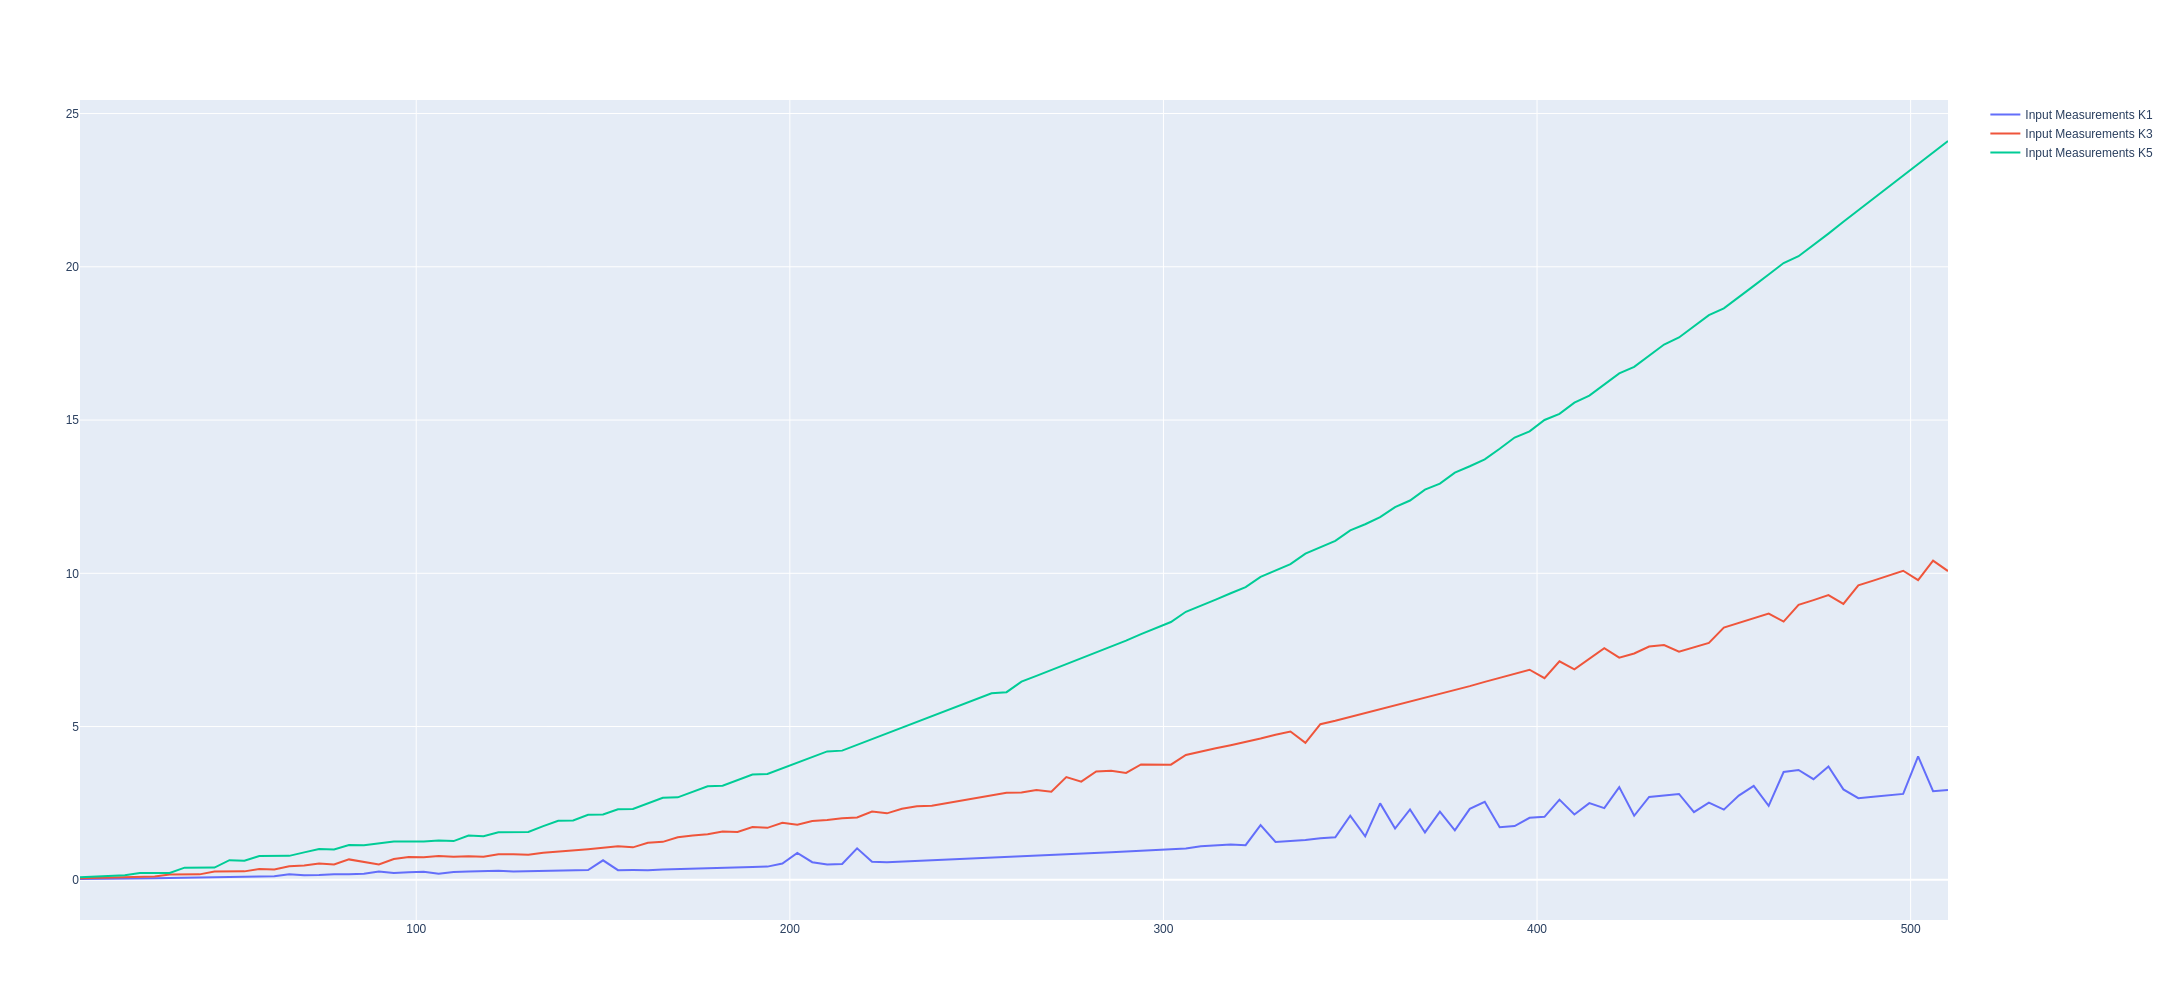

In [12]:
filenames = ["lut_input_sweep_K1x1.csv", "lut_input_sweep_K3x3.csv", "lut_input_sweep_K5x5.csv"]
fig = go.Figure()
# deltas = calculate_deltas(list(split_df.get_group(120)['ms']))
inputs_k1, inputs_k1_meas = load_2d_experiment("lut_input_sweep_K1x1.csv")
inputs_k3, inputs_k3_meas = load_2d_experiment("lut_input_sweep_K3x3.csv")
inputs_k5, inputs_k5_meas = load_2d_experiment("lut_input_sweep_K5x5.csv") 

fig.add_trace(go.Scatter(x=inputs_k1, y=inputs_k1_meas, name=f"Input Measurements K1"))
fig.add_trace(go.Scatter(x=inputs_k3, y=inputs_k3_meas, name=f"Input Measurements K3"))
fig.add_trace(go.Scatter(x=inputs_k5, y=inputs_k5_meas, name=f"Input Measurements K5"))

fig.update_layout(
    autosize=False,
width=PLOT_WIDTH,
height=PLOT_HEIGHT,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    )
fig.show()

In [73]:
# Source - https://stackoverflow.com/a
# Posted by John La Rooy, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-19, License - CC BY-SA 4.0

import os
from glob import glob

result = [y for x in os.walk("./Sweeps") for y in glob(os.path.join(x[0], '*.json'))]


In [75]:
import re
import json
import numpy as np
import pandas as pd
# print(result)
test_str = ""
# Source - https://stackoverflow.com/a
# Posted by Nadia Alramli
# Retrieved 2025-11-19, License - CC BY-SA 2.5
test = "Conv2D_In256_C128_F112_Kx3_Ky3_Sx1_Sy1_Px1_Py1_Dx1_Dx1.json"
characterization = {}
for res in result:
    m = re.match( r'.*In(?P<i>\d+)_C(?P<c>\d+)_F(?P<f>\d+)_Kx(?P<kx>\d+)_Ky(?P<ky>\d+)_Sx(?P<sx>\d+)_Sy(?P<sy>\d+)_Px(?P<px>\d+)_Py(?P<py>\d+)_Dx(?P<dx>\d+)_Dx(?P<dy>\d+)\.json', res)
    if m:
        # print(m.groupdict())
        keys = m.groupdict()
        for key in keys:
            keys[key] = int(keys[key])
        with open(res) as f:
            data = json.load(f)
            # print(data)
            # print(np.mean(data["layers"]["/lut_conv2d/Conv"]["LatencyMS"]))
            if keys["i"] not in characterization:
                characterization[keys["i"]] = {}
            if keys["c"] not in characterization[keys["i"]]:
                characterization[keys["i"]][keys["c"]] = {}
            if keys["f"] not in characterization[keys["i"]][keys["c"]]:
                characterization[keys["i"]][keys["c"]][keys["f"]] = {}
            if keys["kx"] not in characterization[keys["i"]][keys["c"]][keys["f"]]:
                characterization[keys["i"]][keys["c"]][keys["f"]][keys["kx"]] = {}
            if keys["ky"] not in characterization[keys["i"]][keys["c"]][keys["f"]][keys["kx"]]:
                characterization[keys["i"]][keys["c"]][keys["f"]][keys["kx"]][keys["ky"]] = np.mean(data["layers"]["/lut_conv2d/Conv"]["LatencyMS"])

    else:
        print(res)

./Sweeps/lut_channel_sweep.json


In [87]:
characterization_list = []
import plotly.express as px
df = []
print(df)
for c in characterization[256]:
    for f in characterization[256][c]:

        for kx in characterization[256][c][f]:
            for ky in characterization[256][c][f][kx]:
                df.append([c, f, (kx, ky), characterization[256][c][f][kx][ky]])
# print(df)
df = pd.DataFrame(data=df,                columns=["Channels", "Filters", "Kernel","LatencyMS"])
print(df)
import plotly.express as px
fig = px.scatter_3d(df, x='Channels', y='Filters', z='LatencyMS', color="Kernel")
fig.update_layout(width=2000, height=1000, margin=dict(l=0, r=0, b=0, t=0))
fig.show()

[]
      Channels  Filters  Kernel  LatencyMS
0          128      338  (3, 3)  13.605897
1          128      338  (5, 5)  34.520517
2          128       24  (3, 3)   2.793949
3          128       24  (5, 5)   7.066144
4          128      327  (3, 3)  13.563218
...        ...      ...     ...        ...
5626       404      128  (3, 3)  14.899150
5627       404      128  (5, 5)  40.567556
5628       253      128  (3, 3)   8.514450
5629       253      128  (5, 5)  22.618347
5630       707      128  (3, 3)  25.984329

[5631 rows x 4 columns]
